In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import linalg

In [59]:
i1 = cv2.imread('im01.jpg',cv2.IMREAD_COLOR)
i2 = cv2.imread('im02.jpg',cv2.IMREAD_COLOR)
i1 = cv2.cvtColor(i1,cv2.COLOR_BGR2RGB)
i2 = cv2.cvtColor(i2,cv2.COLOR_BGR2RGB)

In [3]:
sift = cv2.xfeatures2d.SIFT_create()
(k1, d1) = sift.detectAndCompute(i1, None)
(k2, d2) = sift.detectAndCompute(i2, None)

[ WARN:0@1.659] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


In [4]:
fig1 = cv2.drawKeypoints(i1, k1, i1, flags = cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
fig2 = cv2.drawKeypoints(i2, k2, i2, flags = cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

out = np.hstack((fig1, fig2)) 
out = np.tile(out, 1)

In [5]:
a = d1.shape[0]
b = d2.shape[0]
t1 = np.zeros(b)
f1 = np.zeros(a)
for i in range(a):
    for j in range(b):
        temp = sum((d1[i]-d2[j])*(d1[i]-d2[j]))
        t1[j] = np.sqrt(temp)
    f1[i] = np.argmin(t1)

t2 = np.zeros(a)
f2 = np.zeros(b)
for i in range(b):
    for j in range(a):
        temp = sum((d2[i]-d1[j])*(d2[i]-d1[j]))
        t2[j] = np.sqrt(temp)
    f2[i] = np.argmin(t2)

In [6]:
def matching(flag1,flag2):
    result = []
    l1 = len(flag1)
    l2 = len(flag2)
    for i in range(l1):
        for j in range(l2):
            if flag1[i]==j and flag2[j]==i:
                result.append([i,flag1[i]])
                
    return result

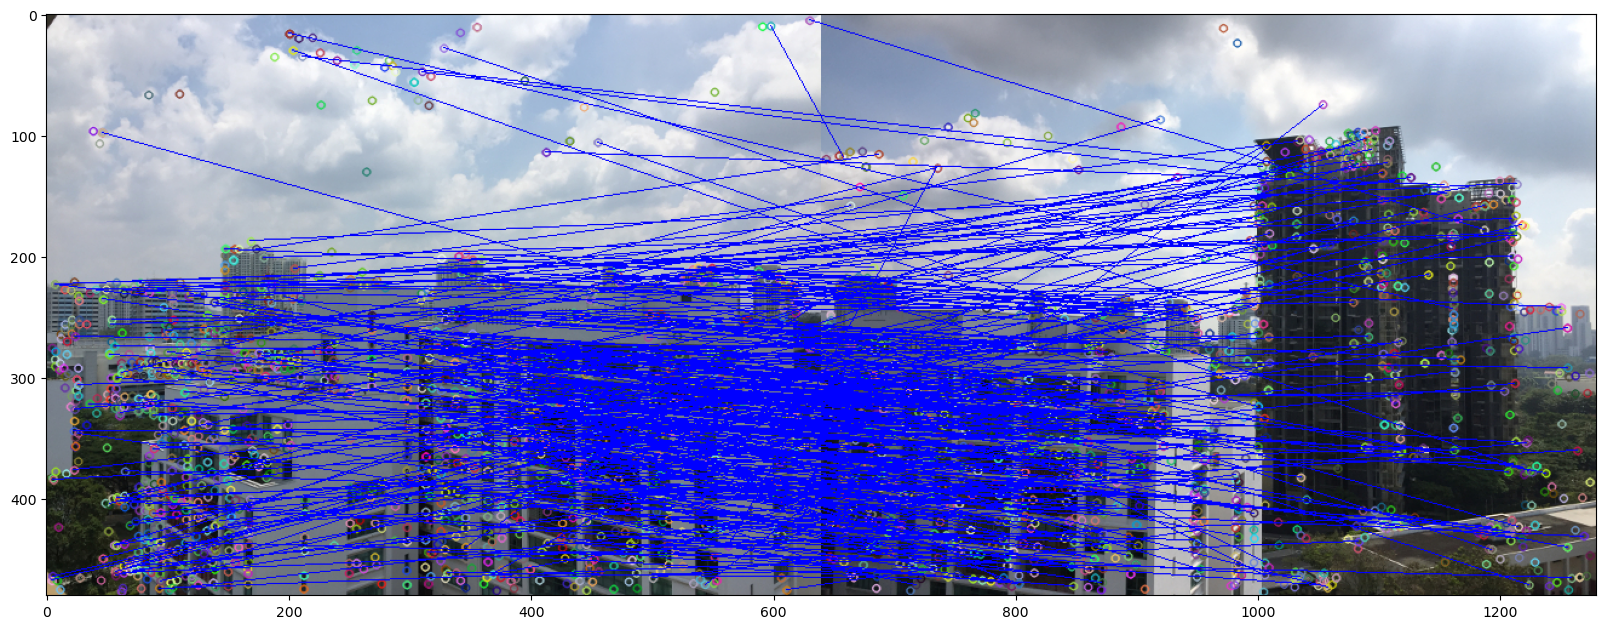

In [11]:
temp = matching(f1,f2)
length = len(temp)
for i in range(length):
    x1 = k1[int(temp[i][0])].pt[0]
    y1 = k1[int(temp[i][0])].pt[1]
    x2 = k2[int(temp[i][1])].pt[0]
    y2 = k2[int(temp[i][1])].pt[1]
    ss = sum((d1[int(temp[i][0])]-d2[int(temp[i][1])])**2)
    d = np.sqrt(ss)
    cv2.line(out,(int(x1),int(y1)),(int(x2)+fig1.shape[1],int(y2)),(0,0,255),1)
    
plt.figure(figsize=(20,10))
plt.imshow(out)
plt.show()

In [12]:
def matrixH(A, B):
    temp = np.zeros([8,9])
    for i in range(4):
        x1 = A[i][0]
        y1 = A[i][1]
        x2 = B[i][0]
        y2 = B[i][1]
        temp[2*i][:] = [x1,y1,1,0,0,0,-x2*x1,-x2*y1,-x2]
        temp[2*i+1][:] = [0,0,0,x1,y1,1,-y2*x1,-y2*y1,-y2]
        
        
    u,d,vt = linalg.svd(temp)
    v = vt[-1,:]
    v = v / v[-1]
    v = np.reshape(v, newshape=(3, 3))
    
    return v/v[2,2]

In [15]:
def randpoint(kp1,kp2,matching):
    a,b,c,d = np.random.randint(0,len(matching),4)
    rand = [a,b,c,d]
    points1 = np.zeros([4,2])
    points2 = np.zeros([4,2])
    for i in range(4):
        points1[i][0] = kp1[int(matching[rand[i]][0])].pt[0]
        points1[i][1] = kp1[int(matching[rand[i]][0])].pt[1]
        points2[i][0] = kp2[int(matching[rand[i]][1])].pt[0]
        points2[i][1] = kp2[int(matching[rand[i]][1])].pt[1]
        
    return points1,points2
        

In [77]:
image2 = np.hstack((fig1, fig2))
e = 1.5
k = 0
iter = 20000
final = []

while k < iter:
    points1,points2 = randpoint(k1,k2,temp)
    H = matrixH(points1,points2)
    
    tt = []        
    for i in range(len(temp)):
        x1 = k1[int(temp[i][0])].pt[0]
        y1 = k1[int(temp[i][0])].pt[1]
        x2 = k2[int(temp[i][1])].pt[0]
        y2 = k2[int(temp[i][1])].pt[1]
        dim = (H[2][0]*x1 + H[2][1]*y1 + H[2][2])
        hx1 = (H[0][0]*x1 + H[0][1]*y1 + H[0][2]) / dim
        hy1 = (H[1][0]*x1 + H[1][1]*y1 + H[1][2]) / dim
        distance = (x2 - hx1)**2 + (y2 - hy1)**2
        distance = np.sqrt(distance)
        if distance < e:
            tt.append(temp[i])
            
    if len(tt) > len(final):
        final = tt 
    
    k =k+1


In [78]:
def draw(mat,kp1,kp2,img,fig):
    src = []
    des = []
    length = len(mat)
    for i in range(length):
        x1 = kp1[int(mat[i][0])].pt[0]
        y1 = kp1[int(mat[i][0])].pt[1]
        p1 = kp2[int(mat[i][1])].pt[0]
        p2 = kp2[int(mat[i][1])].pt[1]
        src.append([x1, y1])
        des.append([p1, p2])
        cv2.line(img,(int(x1),int(y1)),(int(p1) + fig.shape[1],int(p2)),(0,255,0),1)
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()
    
    return src,des

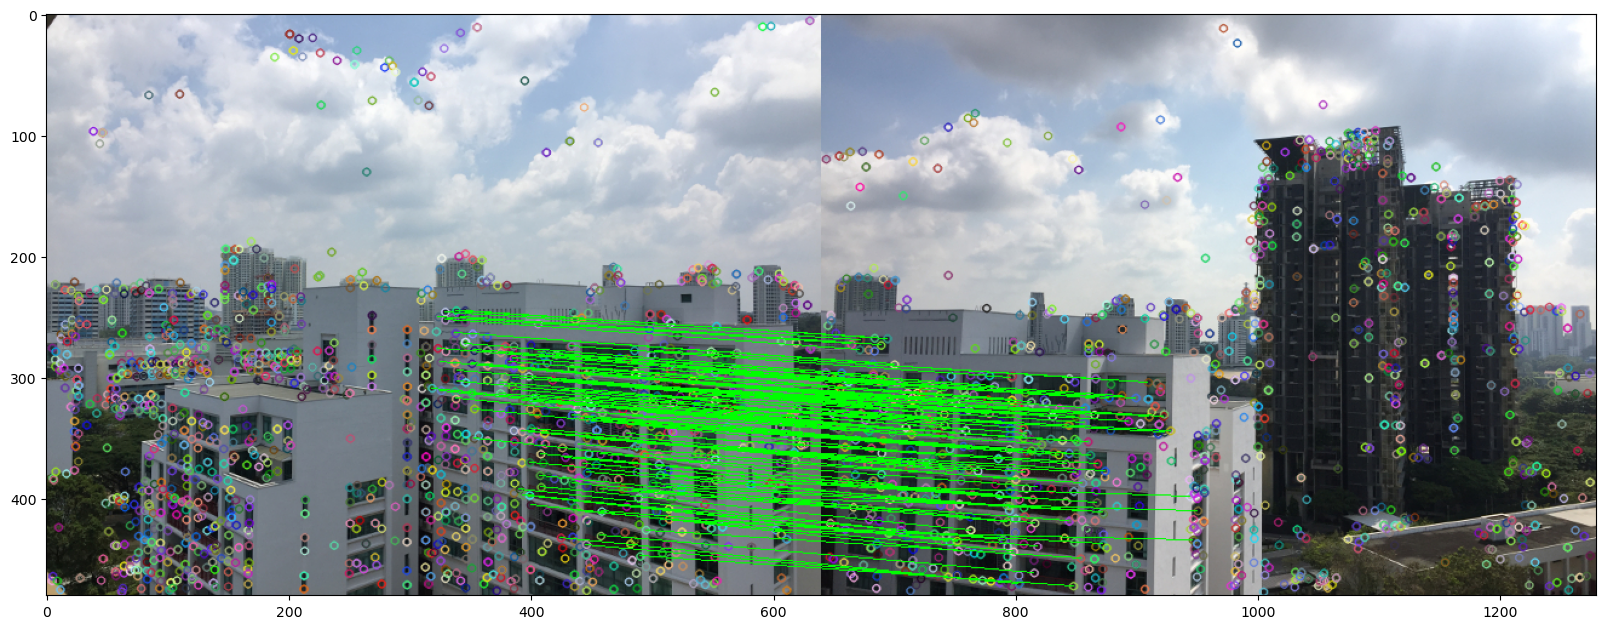

In [88]:
src,des = draw(final,k1,k2,image2,fig1)

In [80]:
print(len(src))

126


In [81]:
print(len(des))

126


In [82]:
def matrixH2(A, B):
    temp = np.zeros([126*2,9])
    for i in range(126):
        x1 = A[i][0]
        y1 = A[i][1]
        x2 = B[i][0]
        y2 = B[i][1]
        temp[2*i][:] = [x1,y1,1,0,0,0,-x2*x1,-x2*y1,-x2]
        temp[2*i+1][:] = [0,0,0,x1,y1,1,-y2*x1,-y2*y1,-y2]
        
        
    u,d,vt = linalg.svd(temp)
    v = vt[8].reshape((3,3))
    
    return v/v[2,2]

In [83]:
a = np.array(src)
b = np.array(des)
Hs2d = matrixH2(a,b)
print(Hs2d)
Hd2s = matrixH2(b,a)
print(Hd2s)

[[ 2.23658311e+00 -1.03403592e-01 -6.59564812e+02]
 [ 5.43987014e-01  1.83139377e+00 -2.01823428e+02]
 [ 1.91098583e-03 -1.39184591e-04  1.00000000e+00]]
[[ 4.34472040e-01  4.66612401e-02  2.95974834e+02]
 [-2.23759257e-01  8.42485169e-01  2.21311964e+01]
 [-8.60255643e-04  2.66768123e-05  1.00000000e+00]]


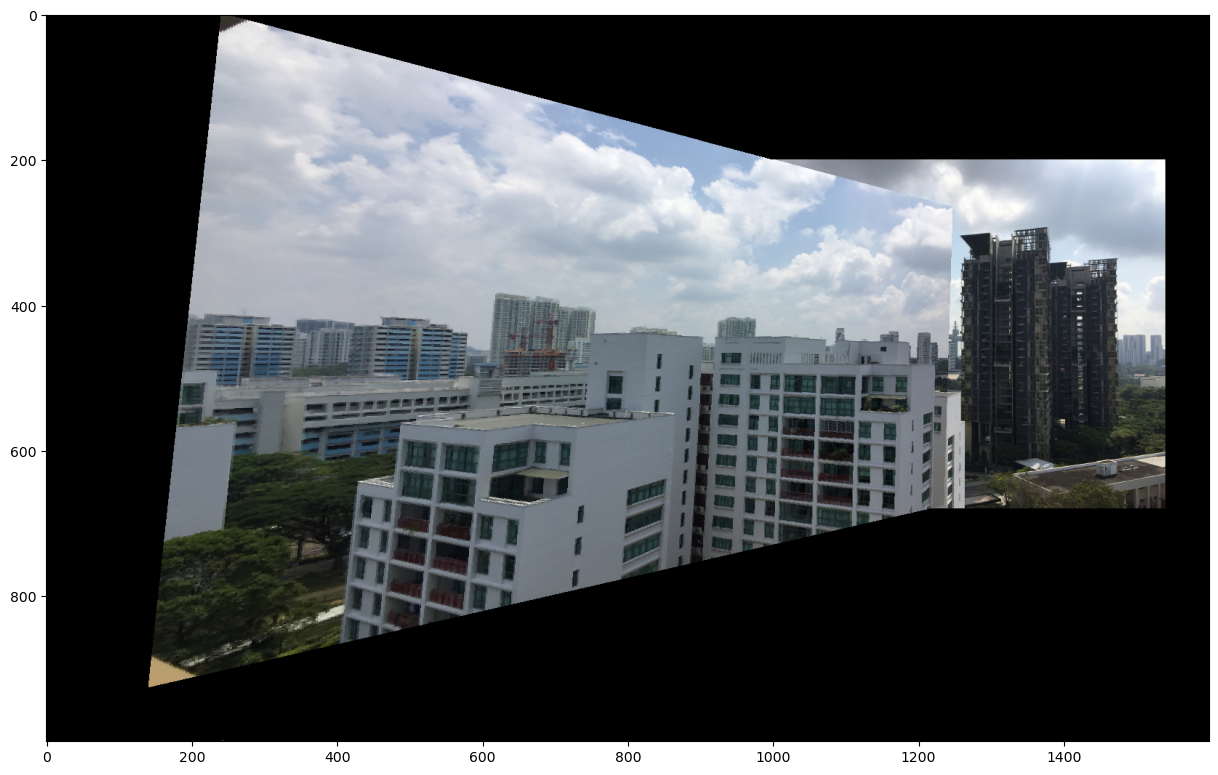

In [87]:
new = np.zeros([1000,1600,3])
H1 = i1.shape[0]
W1 = i1.shape[1]
H2 = i2.shape[0]
W2 = i2.shape[1]

for i in range(200,200+H2):
    for j in range(900,900+W2):
        new[i][j] = i2[i-200][j-900]
        
i = 0
while i<H1:
    j = 0
    while j<W1:
        dim = Hs2d[2][0]*j + Hs2d[2][1]*i + Hs2d[2][2]
        tempx = (Hs2d[0][0]*j + Hs2d[0][1]*i + Hs2d[0][2])/dim
        tempy = (Hs2d[1][0]*j + Hs2d[1][1]*i + Hs2d[1][2])/dim
        new[int(tempy)+200][int(tempx)+900] = i1[int(i)][int(j)]
        j = j+0.2
    i = i+0.2

plt.figure(figsize=(15,15))
plt.imshow(new.astype('uint8'))
plt.show()